In [1]:
import ipywidgets as widgets
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
from HARK.utilities import plot_funcs

import math
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pprint import pprint

from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve

In [2]:
from HARK.ConsumptionSaving.ConsPortfolioModel import init_portfolio

In [3]:
init_portfolio
init_portfolio["cycles"] = 0  # NEED THIS FOR INFINITE HORIZON
init_portfolio["PermGroFac"] = [1.0]  # no drift in perm income
# risk free return, set to 1 to focus on equity premium
init_portfolio["Rfree"] = 1.0
init_portfolio["RiskyAvg"] = 1.05  # eq_prem is RiskyAvg - Rfree = 0.05
init_portfolio["LivPrb"] = [1.0]  # no death
init_portfolio


{'cycles': 0,
 'CRRA': 5.0,
 'Rfree': 1.0,
 'DiscFac': 0.9,
 'LivPrb': [1.0],
 'PermGroFac': [1.0],
 'BoroCnstArt': 0.0,
 'MaxKinks': 400,
 'AgentCount': 10000,
 'aNrmInitMean': 0.0,
 'aNrmInitStd': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'PermGroFacAgg': 1.0,
 'T_age': None,
 'T_cycle': 1,
 'PerfMITShk': False,
 'aXtraMin': 0.001,
 'aXtraMax': 100,
 'aXtraNestFac': 1,
 'aXtraCount': 200,
 'aXtraExtra': [None],
 'PermShkStd': [0.1],
 'PermShkCount': 7,
 'TranShkStd': [0.1],
 'TranShkCount': 7,
 'UnempPrb': 0.05,
 'UnempPrbRet': 0.005,
 'IncUnemp': 0.3,
 'IncUnempRet': 0.0,
 'tax_rate': 0.0,
 'T_retire': 0,
 'vFuncBool': False,
 'CubicBool': False,
 'neutral_measure': False,
 'NewbornTransShk': False,
 'RiskyAvg': 1.05,
 'RiskyStd': 0.2,
 'RiskyCount': 5,
 'ShareCount': 25,
 'AdjustPrb': 1.0,
 'DiscreteShareBool': False}

In [4]:
def interp_func(x, y):
    def func(z):
        return np.interp(z, x, y)

    return func

In [5]:
at = SequentialPortfolioConsumerType(**init_portfolio)
at.track_vars += ["aNrm", "cNrm", "mNrm", "Risky", "Share", "aLvl", "pLvl"]
at.solve()

cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

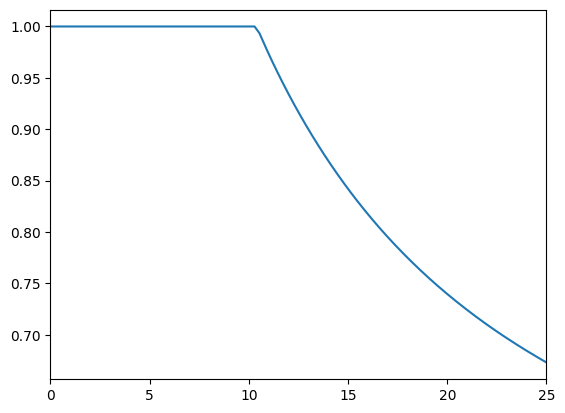

In [6]:
plot_funcs(ShareFunc, 0, 25)

In [7]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983
dividend_shock_std = dividend_std / math.sqrt(dividend_growth_rate)


def price_dividend_ratio_random_walk(DiscFac, CRRA, days_per_quarter=90):
    # Assuming DiscFac in argument in quarterly
    DiscFac_daily = DiscFac ** (1.0 / days_per_quarter)

    subjective_return = (
        dividend_growth_rate ** (1 - CRRA)
        * DiscFac_daily
        * (dividend_shock_std**2 + 1) ** (CRRA * (CRRA - 1) / 2)
    )

    print("subjective_return: " + str(subjective_return))
    return subjective_return < 1

In [8]:
def compute_target_wealth(
    CRRA=5.0,
    DiscFac=0.9,
    RiskyAvg=1.05,
    RiskyStd=0.20,
    PermShkStd=[0.1],
    TranShkStd=[0.1],
):
    agent_parameters = init_portfolio.copy()  # COPY DEFAULT DICTIONARY

    # Replace only exploratory parameters
    agent_parameters["CRRA"] = CRRA
    agent_parameters["DiscFac"] = DiscFac
    agent_parameters["RiskyAvg"] = RiskyAvg
    agent_parameters["RiskyStd"] = RiskyStd
    agent_parameters["PermShkStd"] = PermShkStd
    agent_parameters["TranShkStd"] = TranShkStd

    agent = SequentialPortfolioConsumerType(**agent_parameters)
    # pprint(agent.parameters)

    linear_roots, log_linear_roots, cubic_spline_roots = [], [], []

    try:
        agent.solve()
        solved = True
    except Exception as e:
        solved = False

        return solved, linear_roots, log_linear_roots, cubic_spline_roots

    # subjective return
    srle1 = price_dividend_ratio_random_walk(DiscFac, CRRA)
    print("subjective_return < 1?: " + str(srle1))

    cFunc = agent.solution[0].cFuncAdj
    ShareFunc = agent.solution[0].ShareFuncAdj

    def expected_increase(ShareFunc, cFunc, mNrm):
        share = ShareFunc(mNrm)
        aNrm = mNrm - cFunc(mNrm)

        mNrm_next = (
            aNrm
            * (
                share * agent.parameters["RiskyAvg"]
                + (1 - share) * agent.parameters["Rfree"]
            )
            + 1
        )

        gain = mNrm_next - aNrm
        return gain

    def expected_m_next(mNrm):
        share = ShareFunc(mNrm)
        aNrm = mNrm - cFunc(mNrm)
        mNrm_next = (
            aNrm
            * (
                share * agent.parameters["RiskyAvg"]
                + (1 - share) * agent.parameters["Rfree"]
            )
            + 1  # assuming average income is 1
        )

        return mNrm_next

    mNrm = cFunc.x_list

    # plt.plot(mNrm, cFunc(mNrm), label="c")

    plt.plot(mNrm, mNrm - expected_m_next(mNrm), label="m - E[m']")

    linear_roots = fsolve(interp_func(
        mNrm, mNrm - expected_m_next(mNrm)), [mNrm[0]])
    # log_linear_roots = np.log(
    #     fsolve(interp_func(mNrm, mNrm - expected_m_next(mNrm)), [mNrm[0]])
    # )
    # cubic_spline_roots = CubicSpline(
    #     mNrm, mNrm - expected_m_next(mNrm)).roots()
    print(f"m - E[m] linear interp roots: {linear_roots}")
    # print(f"m - E[m] log roots: {log_linear_roots}")
    # print(f"m - E[m] CubicSpine roots: {cubic_spline_roots}")

    plt.plot(mNrm, np.zeros_like(mNrm), label="0")

    # plt.plot(mNrm, (mNrm - cFunc(mNrm)) * ShareFunc(mNrm), label ="wealth-into-market" )

    plt.legend()

    return solved, linear_roots  # , log_linear_roots, cubic_spline_roots

subjective_return: 0.9994530880363419
subjective_return < 1?: True
m - E[m] linear interp roots: [16.35182267]


(True, array([16.35182267]))

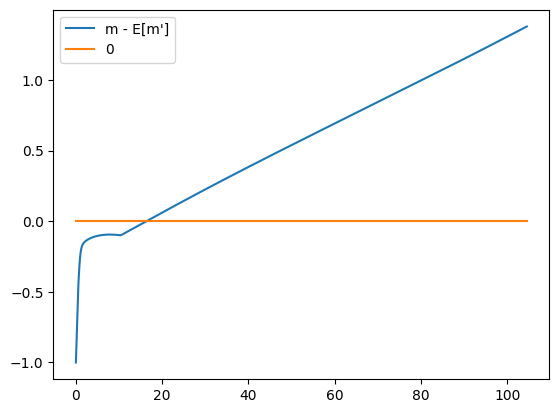

In [9]:
compute_target_wealth()

In [10]:
CRRA_grid = [4.0, 5.0, 6.0]
DiscFac_grid = [0.85, 0.9, 0.95]
RiskyAvg_grid = [1.04, 1.05, 1.06]
RiskyStd_grid = [0.1, 0.2, 0.3]
PermShkStd_grid = [0.0, 0.1, 0.2]
TranShkStd_grid = [0.0, 0.1, 0.2]

subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [1.45546364]


C:\Users\alujan\AppData\Local\Temp\ipykernel_50284\2921339691.py:75: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  linear_roots = fsolve(interp_func(


subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [1.47342658]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [1.53280956]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [1.6439013]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [1.67277071]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [1.76246]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [8.45006899]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [8.47001103]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [8.53029739]
subjective_return: 0.9984478188518532
subjective_return < 1?: True
m - E[m] linear interp roots: [1.44751436]
subjective_ret

C:\Users\alujan\AppData\Local\Temp\ipykernel_50284\2921339691.py:75: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  linear_roots = fsolve(interp_func(


subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [2.36738668]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [2.40558546]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [0.421875]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [0.44140625]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [0.46875]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [2.67348296]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [2.81608284]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [3.26882057]
subjective_return: 0.9996825037734139
subjective_return < 1?: True
m - E[m] linear interp roots: [9.93904762]
subjective_retu

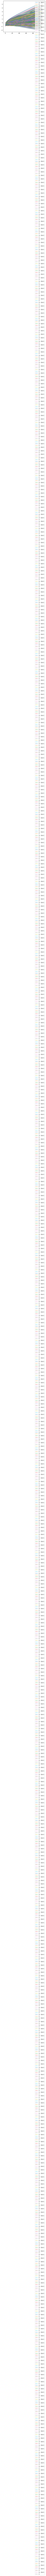

In [11]:
rows = []

for CRRA in CRRA_grid:
    for DiscFac in DiscFac_grid:
        for RiskyAvg in RiskyAvg_grid:
            for RiskyStd in RiskyStd_grid:
                for PermShkStd in PermShkStd_grid:
                    for TranShkStd in TranShkStd_grid:
                        # s, lr, llr, csr = compute_target_wealth(
                        s, lr = compute_target_wealth(
                            CRRA=CRRA,
                            DiscFac=DiscFac,
                            RiskyAvg=RiskyAvg,
                            RiskyStd=RiskyStd,
                            PermShkStd=[PermShkStd],
                            TranShkStd=[TranShkStd],
                        )

                        rows.append(
                            {
                                "CRRA": CRRA,
                                "DiscFac": DiscFac,
                                "RiskyAvg": RiskyAvg,
                                "RiskyStd": RiskyStd,
                                "PermShkStd": PermShkStd,
                                "TranShkStd": TranShkStd,
                                "solved": s,
                                "linear root": lr,
                            }
                        )

In [12]:
df = pd.DataFrame(rows)

In [13]:
df.to_csv("roots.csv")

In [14]:
df.corr()

,CRRA,DiscFac,RiskyAvg,RiskyStd,PermShkStd,TranShkStd,solved,linear root
CRRA,1.000000e+00,-1.039977e-15,6.727943e-14,-3.706454e-16,7.881213e-17,3.726443e-16,NaN,0.142281
DiscFac,-1.039977e-15,1.000000e+00,3.404796e-14,-5.343377e-16,1.674044e-16,5.889493e-17,NaN,-0.060713
RiskyAvg,6.727943e-14,3.404796e-14,1.000000e+00,2.515974e-15,5.648559e-16,2.146096e-16,NaN,-0.088974
RiskyStd,-3.706454e-16,-5.343377e-16,2.515974e-15,1.000000e+00,-7.138780e-19,-2.498573e-18,NaN,-0.076304
PermShkStd,7.881213e-17,1.674044e-16,5.648559e-16,-7.138780e-19,1.000000e+00,1.070817e-17,NaN,0.474199
TranShkStd,3.726443e-16,5.889493e-17,2.146096e-16,-2.498573e-18,1.070817e-17,1.000000e+00,NaN,0.006045
solved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
linear root,1.422809e-01,-6.071337e-02,-8.897363e-02,-7.630406e-02,4.741993e-01,6.044968e-03,NaN,1.000000


In [15]:
list(df[~df["solved"]]["PermShkStd"])

[]

In [16]:
df["solved"].sum()

729

In [17]:
df

,CRRA,DiscFac,RiskyAvg,RiskyStd,PermShkStd,TranShkStd,solved,linear root
0,4.0,0.85,1.04,0.1,0.0,0.0,True,[1.4554636365277995]
1,4.0,0.85,1.04,0.1,0.0,0.1,True,[1.4734265847593322]
2,4.0,0.85,1.04,0.1,0.0,0.2,True,[1.532809555725942]
3,4.0,0.85,1.04,0.1,0.1,0.0,True,[1.6439012966779707]
4,4.0,0.85,1.04,0.1,0.1,0.1,True,[1.672770714359116]
...,...,...,...,...,...,...,...,...
724,6.0,0.95,1.06,0.3,0.1,0.1,True,[0.7822265625017061]
725,6.0,0.95,1.06,0.3,0.1,0.2,True,[0.7822265625017061]
726,6.0,0.95,1.06,0.3,0.2,0.0,True,[0.19140625000041747]
727,6.0,0.95,1.06,0.3,0.2,0.1,True,[0.19140625000041747]
